# Evaluate Dst forecasts

> The baseline is the benchmark by Licata et. al.

In [33]:
# Imports
import sys
sys.path.append('..')
from tsai.basics import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from swdf.utils import *
import wandb
wandb_api = wandb.Api()

In [3]:
# Constants
ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/solfsmy_eval_tmp"

In [63]:
# Config
config = yaml2dict('config/dst.yaml')
config = config.eval
config

```json
{ 'dst_data_path': '../data/DST_IAGA2002.txt',
  'learner_artifact': None,
  'solfsmy_data_path': '../data/SOLFSMY.TXT'}
```

In [5]:
if config.learner_artifact is None:
    learner_path = 'tmp'
else:
    learner_path = wandb_api.artifact(config.learner_artifact).download(root=ARTIFACT_DOWNLOAD_PATH)
learn = load_learner_all('tmp', verbose=True, device='cpu')

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [6]:
y_test_preds, y_test = learn.get_preds(ds_idx = 2, with_targs=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (45888, 1, 144)


In [7]:
horizon = y_test.shape[-1]
data_columns_fcst = ['DST']

The threshold classify the forecasts of Dst are based on the values of the Dst itself
and the solar activity level, as defined by the F10.7 (according to Licata et al.).
Therefore, below is the table of all possible combined conditions to evaluate Dst.

| Dst Level | Solar Level | Dst Value         | Solar Value       |
|-----------|-------------|-------------------|-------------------|
| G0        | Low         | Dst ≥ -30         | F 10.7 ≤ 75       |
| G0        | Moderate    | Dst ≥ -30         | 75 < F 10.7 ≤ 150 |
| G0        | Elevated    | Dst ≥ -30         | 150 < F 10.7 ≤ 190|
| G0        | High        | Dst ≥ -30         | F 10.7 > 190      |
| G1        | Low         | -30 > Dst ≥ -50   | F 10.7 ≤ 75       |
| G1        | Moderate    | -30 > Dst ≥ -50   | 75 < F 10.7 ≤ 150 |
| G1        | Elevated    | -30 > Dst ≥ -50   | 150 < F 10.7 ≤ 190|
| G1        | High        | -30 > Dst ≥ -50   | F 10.7 > 190      |
| G2        | Low         | -50 > Dst ≥ -90   | F 10.7 ≤ 75       |
| G2        | Moderate    | -50 > Dst ≥ -90   | 75 < F 10.7 ≤ 150 |
| G2        | Elevated    | -50 > Dst ≥ -90   | 150 < F 10.7 ≤ 190|
| G2        | High        | -50 > Dst ≥ -90   | F 10.7 > 190      |
| G3        | Low         | -90 > Dst ≥ -130  | F 10.7 ≤ 75       |
| G3        | Moderate    | -90 > Dst ≥ -130  | 75 < F 10.7 ≤ 150 |
| G3        | Elevated    | -90 > Dst ≥ -130  | 150 < F 10.7 ≤ 190|
| G3        | High        | -90 > Dst ≥ -130  | F 10.7 > 190      |
| G4        | Low         | -130 > Dst ≥ -350 | F 10.7 ≤ 75       |
| G4        | Moderate    | -130 > Dst ≥ -350 | 75 < F 10.7 ≤ 150 |
| G4        | Elevated    | -130 > Dst ≥ -350 | 150 < F 10.7 ≤ 190|
| G4        | High        | -130 > Dst ≥ -350 | F 10.7 > 190      |
| G5        | Low         | Dst ≤ -350        | F 10.7 ≤ 75       |
| G5        | Moderate    | Dst ≤ -350        | 75 < F 10.7 ≤ 150 |
| G5        | Elevated    | Dst ≤ -350        | 150 < F 10.7 ≤ 190|
| G5        | High        | Dst ≤ -350        | F 10.7 > 190      |


In order to create all those combined conditions, let's merge the data from Dst
and F10.7. Since this data is provided with different frequencies (1 day for F10.7 
and 1 hour for Dst, we will fill the missing timestamps of F10.7 with forward-filling)


In [8]:
# We'll load again the data from Dst with datetimes, and 
# merge the DATE and TIME columns into a single datetime column
df_dst_raw = pd.read_csv(config.dst_data_path, sep='\s{2,}|\s', 
                         names=['DATE', 'TIME', 'DOY', 'DST'])
df_dst_raw['datetime'] = pd.to_datetime(df_dst_raw.DATE + ' ' + df_dst_raw.TIME)

# We need to load the F10.7 data to classify the DST predictions
df_solfsmy = pd.read_csv(config.solfsmy_data_path, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])

# # Convert the JulianDay column to a datetime column
df_solfsmy['datetime'] = pd.to_datetime(df_solfsmy['JulianDay'], unit='D', origin='julian')
# Shift the datetime from 12:00 to 00:00
df_solfsmy['datetime'] = df_solfsmy['datetime'] - pd.Timedelta(hours=12)

# Merge the DST and F10.7 dataframes on the datetime column, and keep only the columns we need
df_combined = pd.merge(df_dst_raw, df_solfsmy, on='datetime', how='left')
df_combined = df_combined[['datetime', 'DST', 'F10']]

# The F10 is given only at 12:00 (00:00 now that we shifted), so we'll forward 
# fill the rest of the values
df_combined['F10'] = df_combined['F10'].fillna(method='ffill')
df_combined.head()

/tmp/ipykernel_9696/1854806815.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_dst_raw = pd.read_csv(config.dst_data_path, sep='\s{2,}|\s',


,datetime,DST,F10
0,1997-01-01 00:00:00,-5.0,72.4
1,1997-01-01 01:00:00,0.0,72.4
2,1997-01-01 02:00:00,3.0,72.4
3,1997-01-01 03:00:00,6.0,72.4
4,1997-01-01 04:00:00,9.0,72.4


In [56]:
#|export

all_possible_dst_conditions = ['G0_Low', 'G0_Moderate', 'G0_Elevated', 'G0_High',
                                 'G1_Low', 'G1_Moderate', 'G1_Elevated', 'G1_High',
                                 'G2_Low', 'G2_Moderate', 'G2_Elevated', 'G2_High',
                                 'G3_Low', 'G3_Moderate', 'G3_Elevated', 'G3_High',
                                 'G4_Low', 'G4_Moderate', 'G4_Elevated', 'G4_High',
                                 'G5_Low', 'G5_Moderate', 'G5_Elevated', 'G5_High',]

def get_dst_condition(dst, f107):
    """
        Function that returns the Dst condition based on the Dst and F10.7 values.
        Input:
        dst: Dst value (float)
        f107: F10.7 value (float)
        Output:
        dst_condition: Dst condition (string)
    """
    if dst >= -30:
        if f107 <= 75:
            dst_condition = 'G0_Low'
        elif f107 <= 150:
            dst_condition = 'G0_Moderate'
        elif f107 <= 190:
            dst_condition = 'G0_Elevated'
        else:
            dst_condition = 'G0_High'
    elif dst >= -50:
        if f107 <= 75:
            dst_condition = 'G1_Low'
        elif f107 <= 150:
            dst_condition = 'G1_Moderate'
        elif f107 <= 190:
            dst_condition = 'G1_Elevated'
        else:
            dst_condition = 'G1_High'
    elif dst >= -90:
        if f107 <= 75:
            dst_condition = 'G2_Low'
        elif f107 <= 150:
            dst_condition = 'G2_Moderate'
        elif f107 <= 190:
            dst_condition = 'G2_Elevated'
        else:
            dst_condition = 'G2_High'
    elif dst >= -130:
        if f107 <= 75:
            dst_condition = 'G3_Low'
        elif f107 <= 150:
            dst_condition = 'G3_Moderate'
        elif f107 <= 190:
            dst_condition = 'G3_Elevated'
        else:
            dst_condition = 'G3_High'
    elif dst >= -350:
        if f107 <= 75:
            dst_condition = 'G4_Low'
        elif f107 <= 150:
            dst_condition = 'G4_Moderate'
        elif f107 <= 190:
            dst_condition = 'G4_Elevated'
        else:
            dst_condition = 'G4_High'
    else:
        if f107 <= 75:
            dst_condition = 'G5_Low'
        elif f107 <= 150:
            dst_condition = 'G5_Moderate'
        elif f107 <= 190:
            dst_condition = 'G5_Elevated'
        else:
            dst_condition = 'G5_High'
    return dst_condition

# Vectorize the get_dst_condition function
get_dst_condition_vec = np.vectorize(get_dst_condition)

In [39]:
# Add the condition column to the dataframe
df_combined["condition"] = get_dst_condition_vec(df_combined["DST"], 
                                                 df_combined["F10"])

In [ ]:
X_combined, y_combined = prepare_forecasting_data(df_combined, fcst_history=learn.dls.len, fcst_horizon=learn.dls.d[-1], 
                                x_vars=['DST', 'F10', 'datetime'], 
                                y_vars=['DST', 'F10', 'datetime'])
X_combined.shape, y_combined.shape

((230497, 3, 144), (230497, 3, 144))

In [42]:
#| export

def split_data_by_dst_f107(data):
    # function that splits the Dst data into all the possible Dst x F10.7 combinations
    # according to the thresholds defined above. # The decision is made based on 
    # the timestemp of each sample
    # The function returns a dictionary with the Dst x F10.7 combinations as keys
    # and the corresponding samples that match the condition as values.
    # Input:
    # data: Dst data and F10 data (numpy array of shape (n_samples, 2, n_timesteps))
    # Output:
    # data_split: dictionary with the Dst x F10.7 combinations as keys, and the
    # corresponding Dst data as values.

    # Select the first timestep for all samples
    first_timestep_data = data[:, :, 0]

    # Apply the vectorized function to the first timestep data
    result = get_dst_condition_vec(first_timestep_data[:, 0], first_timestep_data[:, 1])

    # Create a dictionary with the Dst x F10.7 combinations as keys and the corresponding
    # samples as values
    data_split = {}
    for dst_condition in np.unique(result):
        data_split[dst_condition] = data[result == dst_condition]
    return data_split

In [54]:
y_combined_train = y_combined[learn.dls[0].splits]
y_combined_valid = y_combined[learn.dls[1].splits]
y_combined_test = y_combined[learn.dls[2].splits]
y_combined_train.shape, y_combined_valid.shape, y_combined_test.shape

((137762, 3, 144), (46417, 3, 144), (45888, 3, 144))

In [73]:
# Splitn y_combined and y_combined_test by Dst x F10.7 combinations
y_combined_train_split = split_data_by_dst_f107(y_combined_train)
y_combined_valid_split = split_data_by_dst_f107(y_combined_valid)
y_combined_test_split = split_data_by_dst_f107(y_combined_test)

# Compare the distributions of the Dst x F10.7 combinations in the training, validation and test sets
print('{:<20} {:<20} {:<20} {}'.format("Condition", "Train", "Valid", "Test"))
for key in all_possible_dst_conditions:
    print('{:<20} {:<20} {:<20} {}'.format(
        key, 
        str(ifnone(y_combined_train_split.get(key),np.array([])).shape),
        str(ifnone(y_combined_valid_split.get(key), np.array([])).shape), 
        str(ifnone(y_combined_test_split.get(key), np.array([])).shape)))

Condition            Train                Valid                Test
G0_Low               (30739, 3, 144)      (24703, 3, 144)      (5667, 3, 144)
G0_Moderate          (66366, 3, 144)      (18035, 3, 144)      (29957, 3, 144)
G0_Elevated          (13836, 3, 144)      (1434, 3, 144)       (4248, 3, 144)
G0_High              (8109, 3, 144)       (232, 3, 144)        (478, 3, 144)
G1_Low               (1130, 3, 144)       (556, 3, 144)        (190, 3, 144)
G1_Moderate          (7515, 3, 144)       (941, 3, 144)        (3240, 3, 144)
G1_Elevated          (2325, 3, 144)       (64, 3, 144)         (544, 3, 144)
G1_High              (1583, 3, 144)       (30, 3, 144)         (74, 3, 144)
G2_Low               (183, 3, 144)        (74, 3, 144)         (24, 3, 144)
G2_Moderate          (2499, 3, 144)       (265, 3, 144)        (1064, 3, 144)
G2_Elevated          (1316, 3, 144)       (14, 3, 144)         (164, 3, 144)
G2_High              (738, 3, 144)        (2, 3, 144)          (0,)
G3_Low       

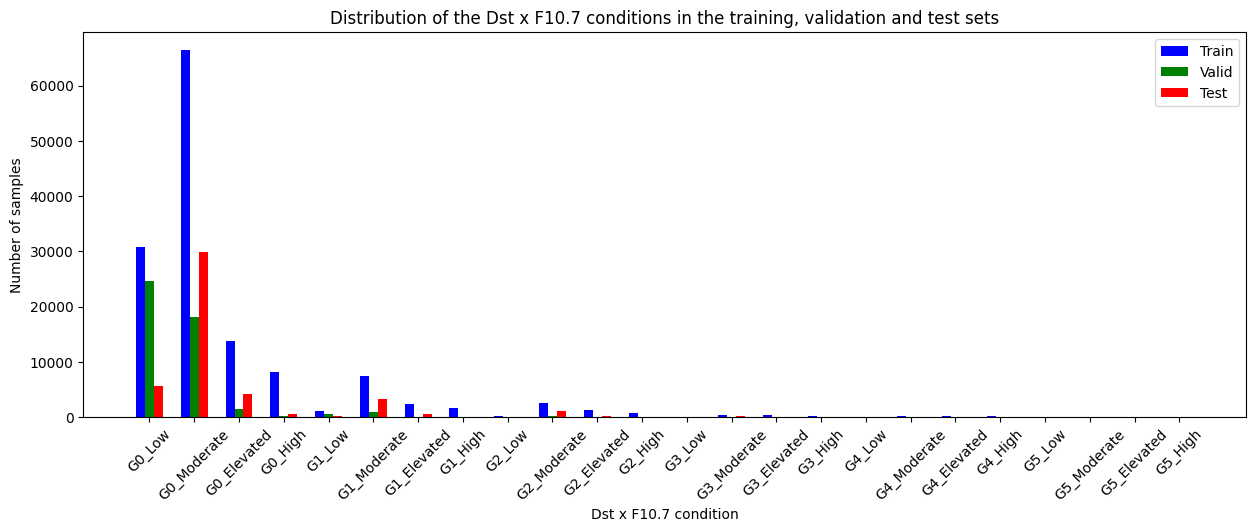

In [76]:
# Compare the distributions dhown in the previous table with a plot
# Plot the distribution of the Dst x F10.7 combinations in the training, validation and test sets
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(all_possible_dst_conditions))-0.2,
        [ifnone(y_combined_train_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='b', align='center', label='Train')
ax.bar(np.arange(len(all_possible_dst_conditions)),
        [ifnone(y_combined_valid_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions], 
        width=0.2, color='g', align='center', label='Valid')
ax.bar(np.arange(len(all_possible_dst_conditions))+0.2,
        [ifnone(y_combined_test_split.get(key),np.array([])).shape[0] for key in all_possible_dst_conditions],
        width=0.2, color='r', align='center', label='Test')
ax.set_xticks(np.arange(len(all_possible_dst_conditions)))
ax.set_xticklabels(all_possible_dst_conditions, rotation=45)
ax.set_ylabel('Number of samples')
ax.set_xlabel('Dst x F10.7 condition')
ax.set_title('Distribution of the Dst x F10.7 conditions in the training, validation and test sets')
ax.legend()
plt.show()